# Source detection

In this first tutorial we are going to learn the power of source detection.
Source detection allow us to automatically identify all the stars detected in our image, being able to calculate accurately their location in detector physical units and estimate their brightness.

When do we want to do this?

1.- To see what stars you have detected in a field compared to a catalogue to identify a new transient

2.- To know the position of different stars

This second option is very powerful if you have hundreds of images to analyse.

Astrometry is the method with which we can measure the RA and Dec of each star. We have a tool called Astrometry.net that allow us to put any field to it and it will identify it and safe the real coordinates. Under linux it is possible to install it and run a script to do astrometry in hundreds of images (it just take a while). However, their webtool can only do one image at a time.

This is where source detection becomes very useful!
Let's see how it works.

In [1]:
%matplotlib inline
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder, CircularAperture
import astropy.io.fits as pf
import numpy as np
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from matplotlib import pyplot as plt

In [2]:
filename = 'rfinalMCT21_1803120162.fits'
image = pf.getdata(filename)

### Sigma clipping

Now that we have loaded our image, let's estimage the background and background noise using sigma-clipping

Sigma-clipping is a techinique on which we estimate the mean and median counts for the whole image, we then ignore anything above a certain sigma and recalculate the mean and median.

In order words, the function finds the average number of counts in the whole image and "throws away" everything higher than X sigma-level assuming that those "bright" pixels are likely stars

In [3]:
mean, median, std = sigma_clipped_stats(image, sigma=3.0)
print("Mean:", mean)
print("Median:", median)
print("Standard deviation:", std)

Mean: 612.2649296241141
Median: 612.2107430375862
Standard deviation: 14.493256726366111


In [4]:
mean, median, std = sigma_clipped_stats(image, sigma=5.0)
print("Mean:", mean)
print("Median:", median)
print("Standard deviation:", std)

Mean: 612.5109966894424
Median: 612.2899229922482
Standard deviation: 15.195166537799555


In [5]:
mean, median, std = sigma_clipped_stats(image, sigma=10.0)
print("Mean:", mean)
print("Median:", median)
print("Standard deviation:", std)

Mean: 612.8462489609403
Median: 612.344935106209
Standard deviation: 16.665722954675317


After running sigma clipping for sigma=3, 5 and 10. Open the image using Ginga (python package) or DS9 (stand alone app) and try to estimate the background yourself.

Which one do you think is closer to reality?

##### Note that this step is very important for the rest since it will be defining what your background is and what is not

Overestimating the background might make you lose faint sources (possible new ones), but underestimating it might make you believe that you have things that are not real.

### Finding sources

It's time to find those stars.
For this we will be using the DAOStarFinder module in photutils.

Note that it requires two parameters:

1.- fwhm: the size of the stars in your images
2.- threshold: the minimum number of counts in units of sigmas above background that you are happy to say: "that's a star"

In reality, when doing photometry, you will want to properly measure your fwhm to know the most effective apperture to maximise your signal-to-noise. - we will do this in another session.

When doing the source detection step, we don't need that level of precission since we are not going to base our photometry on any estimate that source detection give us.

Of course, if we are going to use it (e.g. if we are doing a project in clusters), then we might want to do a proper measurement of fwhm as well.

The fwhm depends on how good/bad the seeing was while taking that image. A bad seeing means a star that spreads over more pixels and thus larger fwhm.

Let's play with the numbers a little bit.

In [6]:
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'

print("Number of sources detected", len(sources))
print()
print(sources) 

Number of sources detected 267

 id xcentroid ycentroid  sharpness  ... sky    peak      flux       mag     
--- --------- ---------- ---------- ... --- --------- --------- ------------
  1 988.57551 0.14934575 0.82943426 ...   0  255.8467 2.1805332  -0.84640675
  2 494.82506 0.60664595   0.409463 ...   0 1719.8597 19.323861   -3.2152348
  3 761.93854  2.7706731 0.37243667 ...   0 121.91508 1.3130616  -0.29571272
  4 22.373359  4.0226155 0.56801331 ...   0 264.87585 2.4445345  -0.97049041
  5 167.34879  5.4109974 0.50257729 ...   0 113.34987 1.0660902 -0.069484927
  6 124.03924   6.101664 0.46863453 ...   0 162.71446 1.5721174  -0.49121242
  7 762.46155  6.8453983 0.57852586 ...   0 215.86967 2.0585678  -0.78391292
  8 639.63361  9.3993231 0.22999189 ...   0  76.91758 1.2397475  -0.23333314
  9  49.84702  19.422926 0.54553838 ...   0 475.23273 4.0164413   -1.5096036
 10  640.8977  33.113083 0.47871552 ...   0 72.292344 1.0430243 -0.045736043
...       ...        ...        ... ... ... 

In [9]:
print(sources['xcentroid'])

xcentroid
---------
988.57551
494.82506
761.93854
22.373359
167.34879
124.03924
762.46155
639.63361
 49.84702
 640.8977
      ...
718.64559
328.85686
553.73307
229.93947
928.72257
827.17708
540.73701
663.33314
837.29677
40.710574
459.12493
Length = 267 rows


See what happens with the number of sources detected when you change the fwhm to 1, 3, 5, 10, 20 and when you change the threshold to 3, 5, 10

Which factor has a bigger impact on the number of detected sources?

Try to identify the faintest source detected in the list and see if you can see it in the image using Ginga/DS9

### Visualisation

We can plot the image with all the sources detected in the previous step

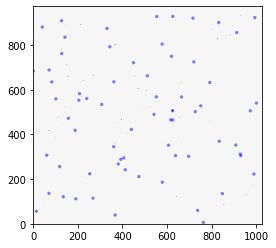

In [20]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.) #choose a number large enough to go over the stars
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(image, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)

### Identifing your source and keeping track of it

Normally telescopes have good tracking and the source(s) we want to study don't move much. But they can move a few pixels.

Use one reference image and with Ginga/DS9 anotate the physical coordinates of your source (reference coords).

Using the steps learned above, find your source(s) and adding a simple condition of +/-50 pixes in X and Y around your reference coordinates, remove all the other sources to make sure that only your source remains.

Save the X, Y coordinates from source finder as the real final position of your source(s) for that image.

You can use the same intial reference coordinates or the ones calculated from the previous image to keep track of the position of your source(s) throughout all your images

##### What would have happened if we would have had astrometry in all of our images?

If we had astrometry done, then we could use astropy to convert the RA and Dec of the source(s) to pixel (or physical) units and we would not have had to do source detection to keep track of our source(s) througout our series of images.